In [25]:
%matplotlib nbagg
import jungfrau_utils as ju
import numpy as np
import json
import os, glob
import time
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import cm
from scipy.optimize import curve_fit
from IPython.display import clear_output, display
import matplotlib.colors as colors

import h5py
from ipyfilechooser import FileChooser

from alvra_tools import *
from alvra_tools.channels import *
#from alvra_tools.channels_raw import *
from scipy.stats.stats import pearsonr

# Load the full scan

In [26]:
fc = FileChooser('/sf/alvra/data/p19198/raw/scan_info/')  #this is for RC
fc.use_dir_icons = True
display(fc)

FileChooser(path='/sf/alvra/data/p19198/raw/scan_info', filename='', show_hidden='False')

In [36]:
quantile_band = 0.2

# channel_list = [channel_LaserDiode]
channel_list = [channel_APD_Ch1, channel_APD_Ch2, channel_Izero117]


################################################################
from sfdata import SFScanInfo
scan = SFScanInfo(fc.selected)
Position_mm = scan.readbacks

Signal_APD1 = []
Signal_APD2 = []
Izero117 = []
Izero122 = []

for i, step in enumerate(scan):
     if i != 35:
        check_files_and_data(step)
        clear_output(wait=True)
        filename = scan.files[i][0].split('/')[-1].split('.')[0]
        print ('Step {} of {}: Processing {}'.format(i+1, len(scan.files), filename))

        results, _ = load_data_compact(channel_list, step)

        Izero117_shot = results[channel_Izero117]      
    #     Izero122_shot = results[channel_Izero122]
        signalAPD1_shot =  results[channel_APD_Ch1]
        signalAPD2_shot =  results[channel_APD_Ch2]

        signalAPD1_norm_shot = signalAPD1_shot / Izero117_shot              #Normalization with PBPS117
        signalAPD2_norm_shot = signalAPD2_shot / Izero117_shot              #Normalization with PBPS117

        #     signal_norm_shot = signal_shot / Izero122_shot              #Normalization with PBPS122

        df_signalAPD1 = pd.DataFrame(signalAPD1_norm_shot)
        Signal_APD1.append(np.nanquantile(df_signalAPD1, [0.5, 0.5 - quantile_band/2, 0.5 + quantile_band/2]))
        
        df_signalAPD2 = pd.DataFrame(signalAPD2_norm_shot)
        Signal_APD2.append(np.nanquantile(df_signalAPD2, [0.5, 0.5 - quantile_band/2, 0.5 + quantile_band/2]))

    #     df_Izero117 = pd.DataFrame(Izero117_shot)
    #     Izero117.append(np.nanquantile(df_Izero117, [0.5, 0.5 - quantile_band/2, 0.5 + quantile_band/2]))
    #     df_Izero122 = pd.DataFrame(Izero122_shot)
    #     Izero122.append(np.nanquantile(df_Izero122, [0.5, 0.5 - quantile_band/2, 0.5 + quantile_band/2]))

Position_mm = Position_mm[:np.shape(Signal_APD1)[0]]
Signal_APD1 = np.asarray(Signal_APD1)
Signal_APD2 = np.asarray(Signal_APD2)
# Izero117 = np.asarray(Izero117)
# Izero122 = np.asarray(Izero122)

print ("Job done!")
print ('Quantiles for error bars: {},{}'.format(0.5 - quantile_band/2, 0.5 + quantile_band/2))

Step 21 of 21: Processing run_009967

--------------------------------------------------------------------------------

SAR-CVME-TIFALL5:EvtSet   252 / 252 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-GES1:CH1_VAL_GET  252 / 252 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-GES1:CH2_VAL_GET  252 / 252 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SAROP11-PBPS117:INTENSITY 252 / 252 -> 0% loss ▇▇▇▇▇▇▇▇▇▇

over the whole data set: 252 / 252 -> 0% loss
complete channels: 4 / 4 -> 0% incomplete

--------------------------------------------------------------------------------

FEL rep rate is 100.0 Hz
Job done!
Quantiles for error bars: 0.4,0.6


<IPython.core.display.Javascript object>


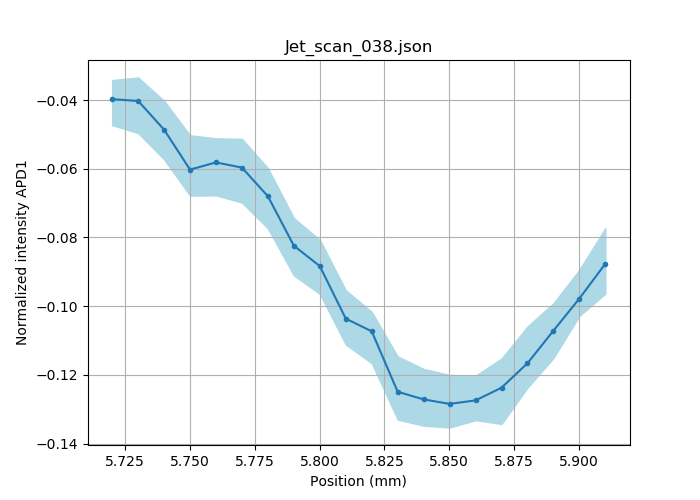

In [37]:
Int_APD1 = Signal_APD1[1:,0]
err_low_APD1 = Signal_APD1[1:,1]
err_high_APD1 = Signal_APD1[1:,2]

plt.figure(figsize=(7,5))
plt.title(fc.selected_filename)
plt.plot(Position_mm[1:], Int_APD1, label='direction X, APD1, {}%'.format(quantile_band*100),marker='.')
plt.fill_between(Position_mm[1:], err_low_APD1, err_high_APD1, color='lightblue')
plt.xlabel("Position (mm)")
plt.ylabel("Normalized intensity APD1")

plt.grid()
plt.show()

<IPython.core.display.Javascript object>


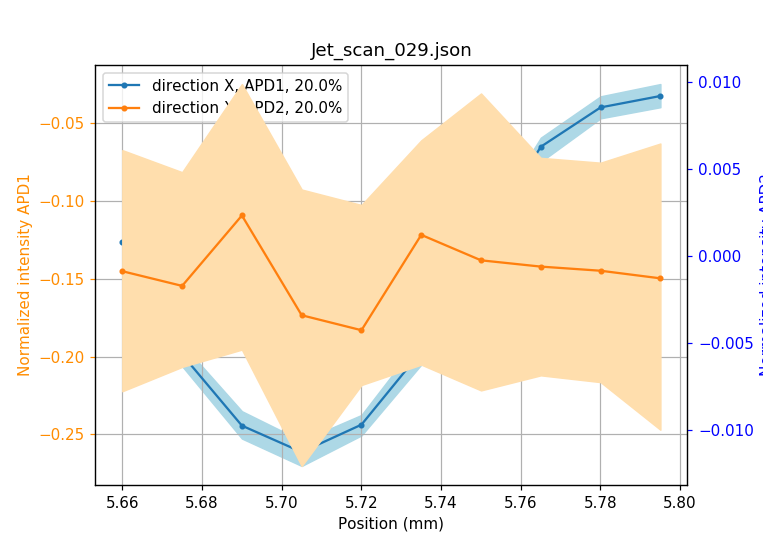

In [21]:
Int_APD1 = Signal_APD1[1:,0]
err_low_APD1 = Signal_APD1[1:,1]
err_high_APD1 = Signal_APD1[1:,2]

Int_APD2 = Signal_APD2[1:,0]
err_low_APD2 = Signal_APD2[1:,1]
err_high_APD2 = Signal_APD2[1:,2]

fig = plt.figure(figsize = (7,5))

ax1 = fig.add_subplot(1,1,1)
ax2 = plt.twinx(ax1)

ax2._get_lines.prop_cycler = ax1._get_lines.prop_cycler


lns1 = ax1.plot(Position_mm[1:], Int_APD1, label='direction X, APD1, {}%'.format(quantile_band*100),marker='.')
ax1.fill_between(Position_mm[1:], err_low_APD1, err_high_APD1, color='lightblue')

lns2 = ax2.plot(Position_mm[1:], Int_APD2, label='direction X, APD2, {}%'.format(quantile_band*100),marker='.')
ax2.fill_between(Position_mm[1:], err_low_APD2, err_high_APD2, color='navajowhite')


plt.title(fc.selected_filename)

ax1.set_xlabel("Position (mm)")

ax1.set_ylabel ("Normalized intensity APD1")
ax1.tick_params(axis='y', colors='darkorange')
ax1.yaxis.label.set_color('darkorange')

ax2.set_ylabel ("Normalized intensity APD2")
ax2.tick_params(axis='y', colors='b')
ax2.yaxis.label.set_color('b')


leg = lns1 + lns2
labels = [l.get_label() for l in leg]
ax1.legend(leg, labels, loc='best')
ax1.grid()

plt.show()